In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# long_table = pd.read_csv(
#     '/project2/yangili1/bjf79/ChromatinSplicingQTLs/code/SplicingAnalysis/CombinedJuncTables/YRI.tsv.gz', sep='\t'
# )

# long_table['intron_count'] = [1]*len(long_table)

# polyA = long_table.loc[long_table.Dataset.isin(
#     ['Expression.Splicing']) & (long_table.RepNumber == '1.junc')
#                       ].groupby(['chrom', 'start', 'stop', 'strand'])['Count', 'intron_count'].sum().reset_index()

# chRNA = long_table.loc[long_table.Dataset.isin(
#     ['chRNA.Expression.Splicing']) & (long_table.RepNumber == '1.junc')
#                       ].groupby(['chrom', 'start', 'stop', 'strand'])['Count', 'intron_count'].sum().reset_index()

# del long_table

/tmp/ipykernel_89846/1355143005.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  polyA = long_table.loc[long_table.Dataset.isin(
/tmp/ipykernel_89846/1355143005.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  chRNA = long_table.loc[long_table.Dataset.isin(


In [3]:
polyA

,chrom,start,stop,strand,Count,intron_count
0,chr1,12721,13220,+,5,3
1,chr1,14695,185174,-,1,1
2,chr1,14829,15020,-,1,1
3,chr1,15038,15795,-,251,61
4,chr1,15561,15795,-,1,1
...,...,...,...,...,...,...
898317,chr9,138278829,138279387,-,2,2
898318,chr9,138281016,138281772,+,1,1
898319,chr9,138284022,138286247,+,1,1
898320,chr9,138286416,138287377,+,2,2


In [8]:
long_table.groupby(['chrom', 'start', 'stop', 'strand']).Count.sum().reset_index()

,chrom,start,stop,strand,Count
0,chr1,12721,13220,+,5
1,chr1,14695,185174,-,1
2,chr1,14829,15020,-,1
3,chr1,15038,15795,-,251
4,chr1,15561,15795,-,1
...,...,...,...,...,...
898317,chr9,138278829,138279387,-,2
898318,chr9,138281016,138281772,+,1
898319,chr9,138284022,138286247,+,1
898320,chr9,138286416,138287377,+,2


In [14]:
exons = pd.read_csv('../../EVENT_INFO-hg38.tab.gz', sep='\t')[['EVENT', 'COMPLEX', 'CO_C1', 'CO_A', 'CO_C2', 'LE_n']].dropna()

In [3]:
impact = pd.read_csv('../../PROT_IMPACT-hg38-v3.tab.gz', sep='\t')
cons = pd.read_csv('../../EVENT_CONSERVATION.tab.gz', sep='\t')


KeyboardInterrupt



In [6]:
exon = exons.EVENT
LE = exons.LE_n
c1 = exons.CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1

In [40]:
df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)

df = df.merge(polyA, left_on = ['chrom', 'donor_c1', 'receptor_c1'], right_on=['chrom', 'start', 'stop'], how='left')
df = df.merge(polyA, left_on = ['chrom', 'donor_c2', 'receptor_c2'], right_on=['chrom', 'start', 'stop'], how='left')
df = df.merge(polyA, left_on = ['chrom', 'donor_c1', 'receptor_c2'], right_on=['chrom', 'start', 'stop'], how='left')

df = df.fillna(0)
df['PSI'] = (df.Count + df.Count_x)/((df.Count + df.Count_x)+ (2*df.Count_y))
df['PSI_c1'] = (df.Count)/(df.Count + df.Count_x + df.Count_y)
df['PSI_c2'] = (df.Count_x)/(df.Count + df.Count_x + df.Count_y)
df = df.loc[~df.PSI.isna()]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].EventID)]

# df = df.loc[((df.PSI_c1 - df.PSI_c2).abs() < 0.9) | ((df.Count + df.Count_x)<10)]

In [47]:
# df = df.loc[ ([x[:5]=='HsaEX' for x in df.event])]
df = df.loc[(((df.intron_count > 50) & (df.intron_count_x > 50)) | (df.intron_count_y > 100)) & ([x[:5]=='HsaEX' for x in df.event])]

In [50]:
df = df.loc[((df.PSI_c1 - df.PSI_c2).abs() < 0.1) | ((df.Count + df.Count_x)>100)]

In [42]:
x = np.linspace(0.333, 1, 3)

In [48]:
x

array([0.333 , 0.6665, 1.    ])

In [49]:
polyA_ = []
for i in x:
    polyA_.append((df.loc[(df.PSI>i-0.333) & (df.PSI<=i)].LE_n%3==0).mean())

In [50]:
polyA_

[0.47265625, 0.5488599348534202, 0.43991416309012876]

Text(0.5, 1.0, 'polyA data')

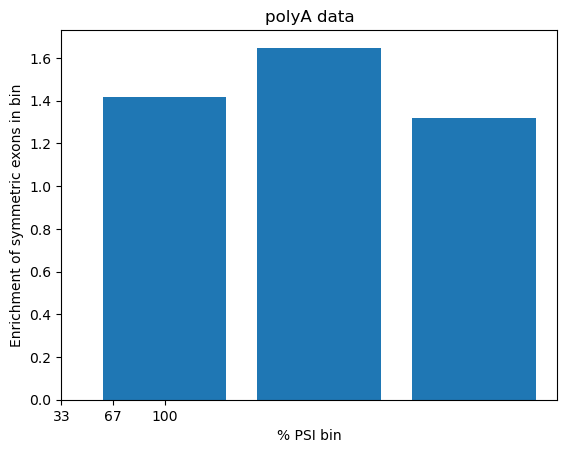

In [51]:
plt.bar(range(1, 4), np.array(polyA_)/0.333)
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(x, ['33', '67', '100'])
plt.title('polyA data')

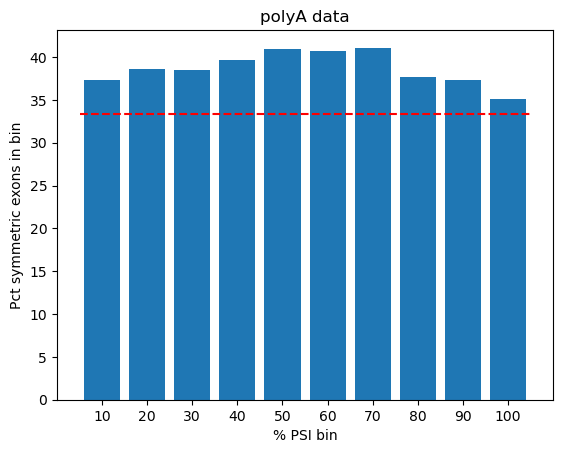

In [181]:
plt.bar(range(1, 11), 100*np.array(polyA_))
plt.ylabel('Pct symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(x*10, ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])
plt.title('polyA data')
plt.plot([0.5, 10.5], [33.333, 33.333], 'r--')

In [83]:
(df.LE_n%3==0).mean()

0.3638480139946491

In [482]:
metrics = pd.read_csv('../../EVENT_METRICS-hg38.tab.gz', sep='\t')

In [127]:
exons_ = exons.merge(metrics, left_on='EVENT', right_on='EVENT')

In [141]:
(exons_.loc[exons_.Average < 0.1].LE_n%3==0).mean()

0.3544753691362864

In [139]:
(exons_.LE_n%3 == 0).mean()

0.3666946225081668

In [479]:
exons_ = exons.merge(metrics, left_on='EVENT', right_on='EVENT')
db_ = []
for i in x:
    db_.append((exons_.loc[(exons_.Average>i-0.1) & (exons_.Average<=i)].LE_n%3==0).mean())

Text(0.5, 1.0, 'VastDB data')

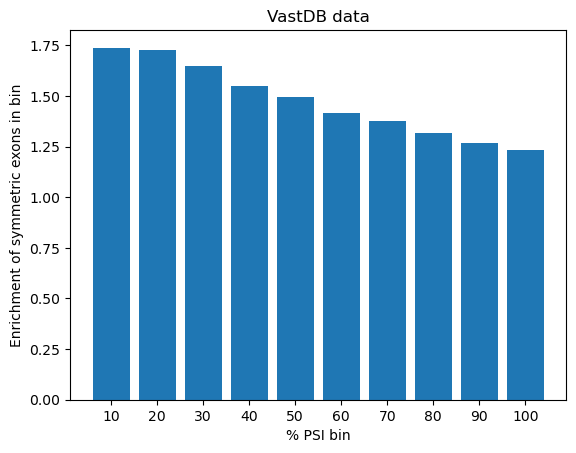

In [480]:
plt.bar(range(1, 11), np.array(db_)/0.333)
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(x*10, ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])
plt.title('VastDB data')

In [150]:
impact = pd.read_csv('../../PROT_IMPACT-hg38-v3.tab.gz', sep='\t')

In [165]:
df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].EventID)]
# impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])]

,event,chrom,donor_c1,receptor_c1,donor_c2,receptor_c2,LE_n,start_x,stop_x,strand_x,...,stop_y,strand_y,Count_y,start,stop,strand,Count,PSI,PSI_c1,PSI_c2
14,HsaEX0000301,chr19,1042176,1042314,1042397,1042745,83,1042176.0,1042314.0,+,...,1042745.0,+,467.0,0.0,0.0,0,0.0,0.390339,0.00000,0.561502
15,HsaEX0000317,chr19,1058059,1058145,1058269,1058617,124,1058059.0,1058145.0,+,...,1058617.0,+,1989.0,0.0,0.0,0,0.0,0.333222,0.00000,0.499874
18,HsaEX0000537,chr1,94478315,94480463,94480606,94483169,143,94478315.0,94480463.0,+,...,94483169.0,+,2764.0,0.0,0.0,0,0.0,0.316265,0.00000,0.480549
19,HsaEX0000578,chr11,119154915,119156328,119156452,119156563,124,0.0,0.0,0,...,119156563.0,+,2.0,0.0,0.0,0,0.0,0.000000,0.00000,0.000000
20,HsaEX0000758,chr3,127677843,127679572,127679679,127679984,107,127677843.0,127679572.0,+,...,127679984.0,+,20.0,127677843.0,127679984.0,+,1084.0,0.964664,0.97482,0.007194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594250,HsaEX1014146,chr8,93705010,93709759,93709767,93709770,8,0.0,0.0,0,...,0.0,0,0.0,93705010.0,93709770.0,+,4.0,1.000000,1.00000,0.000000
594254,HsaEX1024660,chr12,101595095,101607550,101607553,101614495,3,0.0,0.0,0,...,0.0,0,0.0,101595095.0,101614495.0,+,2.0,1.000000,1.00000,0.000000
594269,HsaEX6059108,chr3,150603499,150614572,150614583,150622384,11,0.0,0.0,0,...,0.0,0,0.0,150603499.0,150622384.0,+,14432.0,1.000000,1.00000,0.000000
594270,HsaEX1039457,chr1,226596981,226601994,226601999,226602005,5,0.0,0.0,0,...,0.0,0,0.0,226596981.0,226602005.0,+,13.0,1.000000,1.00000,0.000000


In [166]:
df.shape

(233232, 22)

In [157]:
impact

,EventID,ONTO
0,HsaEX0000026,NonCoding
1,HsaEX0000056,NonCoding
2,HsaEX0000064,NonCoding
3,HsaEX0000080,NonCoding
4,HsaEX0000090,NonCoding
...,...,...
721639,HsaINT0085241,ORF disruption upon sequence inclusion
721640,HsaINT0085242,ORF disruption upon sequence inclusion
721641,HsaINT0085243,ORF disruption upon sequence inclusion
721642,HsaINT0085244,ORF disruption upon sequence inclusion


In [158]:
df.merge()

,event,chrom,donor_c1,receptor_c1,donor_c2,receptor_c2,LE_n,start_x,stop_x,strand_x,...,stop_y,strand_y,Count_y,start,stop,strand,Count,PSI,PSI_c1,PSI_c2
0,HsaEX0000026,chr12,120209934,120210929,120211106,120212374,177,120209934.0,120210929.0,+,...,120212374.0,+,179.0,120209934.0,120212374.0,+,1299.0,0.829035,0.678329,0.228198
1,HsaEX0000056,chr14,28832060,28837252,28837330,28841803,78,28832060.0,28837252.0,+,...,28841803.0,+,1.0,28832060.0,28841803.0,+,1.0,0.900000,0.052632,0.894737
14,HsaEX0000301,chr19,1042176,1042314,1042397,1042745,83,1042176.0,1042314.0,+,...,1042745.0,+,467.0,0.0,0.0,0,0.0,0.390339,0.000000,0.561502
15,HsaEX0000317,chr19,1058059,1058145,1058269,1058617,124,1058059.0,1058145.0,+,...,1058617.0,+,1989.0,0.0,0.0,0,0.0,0.333222,0.000000,0.499874
18,HsaEX0000537,chr1,94478315,94480463,94480606,94483169,143,94478315.0,94480463.0,+,...,94483169.0,+,2764.0,0.0,0.0,0,0.0,0.316265,0.000000,0.480549
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594254,HsaEX1024660,chr12,101595095,101607550,101607553,101614495,3,0.0,0.0,0,...,0.0,0,0.0,101595095.0,101614495.0,+,2.0,1.000000,1.000000,0.000000
594268,HsaEX1036423,chr3,150603499,150608699,150608702,150622384,3,0.0,0.0,0,...,0.0,0,0.0,150603499.0,150622384.0,+,14432.0,1.000000,1.000000,0.000000
594269,HsaEX6059108,chr3,150603499,150614572,150614583,150622384,11,0.0,0.0,0,...,0.0,0,0.0,150603499.0,150622384.0,+,14432.0,1.000000,1.000000,0.000000
594270,HsaEX1039457,chr1,226596981,226601994,226601999,226602005,5,0.0,0.0,0,...,0.0,0,0.0,226596981.0,226602005.0,+,13.0,1.000000,1.000000,0.000000


In [160]:
polyA

,chrom,start,stop,strand,Count
0,chr1,12721,13220,+,5
1,chr1,14695,185174,-,1
2,chr1,14829,15020,-,1
3,chr1,15038,15795,-,251
4,chr1,15561,15795,-,1
...,...,...,...,...,...
898317,chr9,138278829,138279387,-,2
898318,chr9,138281016,138281772,+,1
898319,chr9,138284022,138286247,+,1
898320,chr9,138286416,138287377,+,2


In [202]:
(exons.COMPLEX == 'IR').mean()

0.26776478751084126

In [192]:
exons.COMPLEX.unique()

array(['A_S', 'A_C3', 'A_C1', 'A_C2', 'A_NA', 'ANN', 'C3', 'S', 'C1',
       'C1*', 'S*', 'C3*', 'C2', 'C2*', 'ME(1-2[100=96])',
       'ME(13_22-14_23[100=100])', 'ME(29_31-30_32[100=100])',
       'ME(4-5[100=98])', 'ME(57_45-58_44[100=100])',
       'ME(53_45-54_44[100=100])', 'ME(1-2[96=100])',
       'ME(25_28-26_29[98=93])', 'ME(34_30-35_31[100=98])',
       'ME(2-3[99=98])', 'ME(13-14[100=100])', 'MIC-S',
       'ME(226_176-227_177[100=100])', 'ME(4-5[100=100])',
       'ME(2-3[95=100])', 'ME(1-3[100=100])', 'ME(1-2[100=100])',
       'ME(14_28-15_27[100=100])', 'ME(30_31-31_32[100=96])',
       'ME(14-15[99=99])', 'ME(1-2[97=92])', 'ME(1-2[95=97])',
       'ME(1-2[100=100];2-3[98=100])', 'ME(34_26-35_25[100=100])',
       'ME(23_26-24_27[100=100])', 'ME(30_37-31_38[100=100])',
       'ME(1-2[99=100];2-3[99=100])', 'ME(1-3[100=100];2-3[99=100])',
       'ME(10-11[92=100])', 'ME(33_29-34_28[100=100])', 'ME(5-6[100=97])',
       'ME(2-3[100=100])', 'ME(10-11[99=96])', 'ME(1-2[95=1

In [219]:
((exons.loc[exons.COMPLEX=='A_C1'].LE_n%3)==0).mean()

0.3698152216048585

In [221]:
cons = pd.read_csv('../../EVENT_CONSERVATION.tab.gz', sep='\t')

/project2/mstephens/cfbuenabadn/anaconda3/envs/jnotebook/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3266: DtypeWarning: Columns (4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [224]:
cons = cons.loc[cons.Ass1 == 'hg38']

In [246]:
cons.Type.unique()

array(['ALTERNATIVE', '\\N', 'HIGH PSI', 'LOW PSI'], dtype=object)

In [434]:
exon = exons.loc[exons.COMPLEX.isin(['S', 'A_S'])].EVENT
LE = exons.loc[exons.COMPLEX.isin(['S', 'A_S'])].LE_n
c1 = exons.loc[exons.COMPLEX.isin(['S', 'A_S'])].CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.loc[exons.COMPLEX.isin(['S', 'A_S'])].CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.loc[exons.COMPLEX.isin(['S', 'A_S'])].CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1

In [387]:
exon = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])].dropna().EVENT
LE = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])].dropna().LE_n
c1 = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])].dropna().CO_C1.str.split('-', expand=True)
chrom = c1[0].str.split(':', expand=True)[0]
donor_c1 = c1[1].astype(int)

ca = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])].dropna().CO_A.str.split('-', expand=True)
receptor_c1 = ca[0].str.split(':', expand=True)[1].astype(int) - 1
donor_c2 = ca[1].astype(int)

c2 = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])].dropna().CO_C2.str.split('-', expand=True)
receptor_c2 = c2[0].str.split(':', expand=True)[1].astype(int) - 1

In [457]:
df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)

df = df.merge(chRNA, left_on = ['chrom', 'donor_c1', 'receptor_c1'], right_on=['chrom', 'start', 'stop'], how='left')
df = df.merge(chRNA, left_on = ['chrom', 'donor_c2', 'receptor_c2'], right_on=['chrom', 'start', 'stop'], how='left')
df = df.merge(chRNA, left_on = ['chrom', 'donor_c1', 'receptor_c2'], right_on=['chrom', 'start', 'stop'], how='left')

df = df.fillna(0)
df['PSI'] = (df.Count + df.Count_x)/((df.Count + df.Count_x)+ (2*df.Count_y))
df['PSI_c1'] = (df.Count)/(df.Count + df.Count_x + df.Count_y)
df['PSI_c2'] = (df.Count_x)/(df.Count + df.Count_x + df.Count_y)
df = df.loc[~df.PSI.isna()]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].EventID)]

# df = df.loc[((df.PSI_c1 - df.PSI_c2).abs() < 0.9) | ((df.Count + df.Count_x)<10)]

In [458]:
df_ = df.loc[df.event.isin(cons.loc[cons.Type == 'ALTERNATIVE'].EventID) & (
    (df.PSI_c1 - df.PSI_c2).abs()<0.9) & ((df.Count + df.Count_x + df.Count_y)>500)]

In [436]:
df_ = df.loc[(
    (df.PSI_c1 - df.PSI_c2).abs()<0.9) & ((df.Count + df.Count_x + df.Count_y)>500)]

In [459]:
polyA_ = []
for i in x:
    polyA_.append(((df_.loc[(df_.PSI>i-0.1) & (df_.PSI<=i)].LE_n%3)==0).mean())

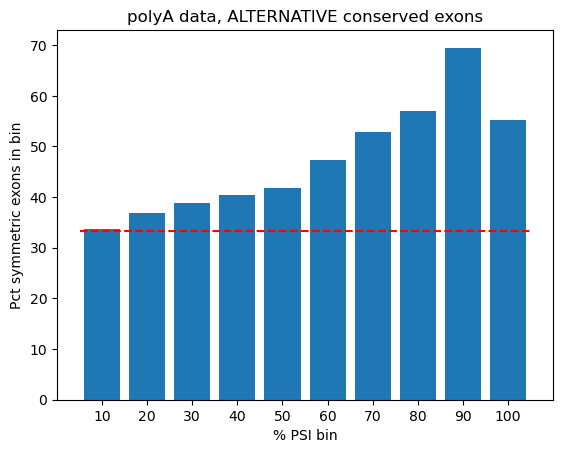

In [460]:
plt.bar(range(1, 11), 100*np.array(polyA_))
plt.ylabel('Pct symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(x*10, ['10', '20', '30', '40', '50', '60', '70', '80', '90', '100'])
plt.title('polyA data, ALTERNATIVE conserved exons')
plt.plot([0.5, 10.5], [33.333, 33.333], 'r--')

In [296]:
df.Count + df.Count_x + df.Count_y

0          1915.0
1            19.0
14         1065.0
15         3977.0
18         5321.0
           ...   
594254        2.0
594268    14432.0
594269    14432.0
594270       13.0
594277        1.0
Length: 233232, dtype: float64

In [445]:
metrics

,EventID,ONTO
0,HsaEX0000026,NonCoding
1,HsaEX0000056,NonCoding
2,HsaEX0000064,NonCoding
3,HsaEX0000080,NonCoding
4,HsaEX0000090,NonCoding
...,...,...
721639,HsaINT0085241,ORF disruption upon sequence inclusion
721640,HsaINT0085242,ORF disruption upon sequence inclusion
721641,HsaINT0085243,ORF disruption upon sequence inclusion
721642,HsaINT0085244,ORF disruption upon sequence inclusion


In [564]:
exons_ = exons.merge(metrics, left_on='EVENT', right_on='EVENT')
# db_ = []
# for i in x:
#     db_.append((exons_.loc[(exons_.Average>i-0.1) & (exons_.Average<=i)].LE_n%3==0).mean())

In [544]:
exons_ = exons_.loc[exons_.EVENT.isin(
    impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].EventID)]

In [465]:
((exons_.loc[(exons_.Average > 90) & (exons_.Average < 900)].LE_n%3)==0).mean()

0.4030436273422215

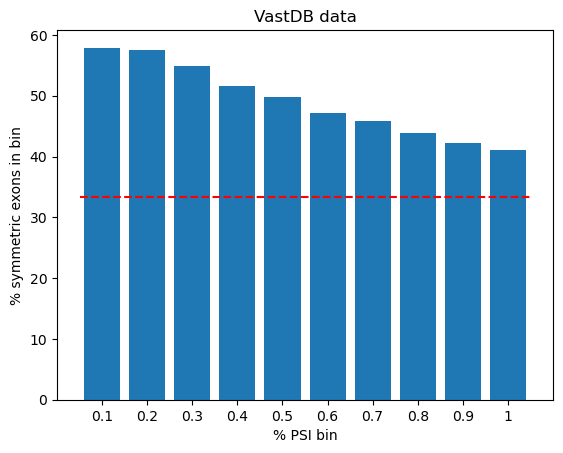

In [565]:
# exons_ = exons.merge(metrics, left_on='EVENT', right_on='EVENT')
x_ = np.linspace(0.1, 1, 10)
db_ = []
for i in x_:
    db_.append((exons_.loc[(exons_.Average>i-0.1) & (exons_.Average<=i)].LE_n%3==0).mean())
    
plt.bar(range(1, 11), np.array(db_)*100)
plt.ylabel('% symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(x*10, ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'])
plt.title('VastDB data')
plt.plot([0.5, 10.5], [33.333, 33.333], 'r--')

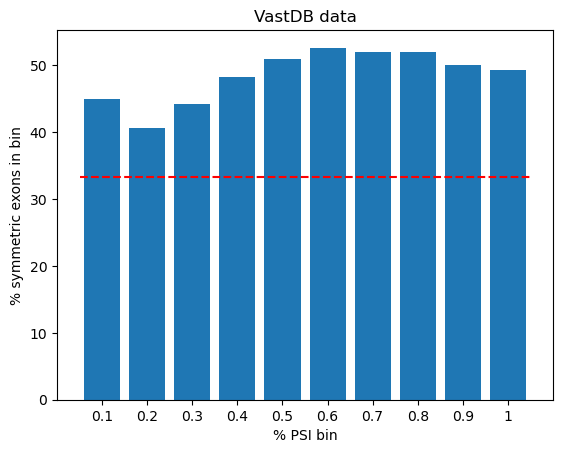

In [566]:
# exons_ = exons.merge(metrics, left_on='EVENT', right_on='EVENT')
x_ = np.linspace(0.1, 1, 10)*100
db_ = []
for i in x_:
    db_.append((exons_.loc[(exons_.Average>i-10) & (exons_.Average<=i)].LE_n%3==0).mean())
    
plt.bar(range(1, 11), np.array(db_)*100)
plt.ylabel('% symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(x*10, ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1'])
plt.title('VastDB data')
plt.plot([0.5, 10.5], [33.333, 33.333], 'r--')

In [494]:
exons_.loc[(exons_.Average>0.1-0.1) & (exons_.Average<=0.1)].LE_n

606         80
1292       121
2005        11
2320        73
2474      1476
          ... 
200557      85
200648      91
200752      59
201220     140
201275     101
Name: LE_n, Length: 2184, dtype: int64

In [530]:
x

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [235]:
polyA_psi = pd.read_csv('../code/QTLs/QTLTools/polyA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')
chRNA_psi = pd.read_csv('../code/QTLs/QTLTools/chRNA.Splicing/OnlyFirstReps.PSI.bed.gz', sep='\t')

In [236]:
exons = exons.loc[~exons.COMPLEX.isin(['MIC_S', 'IR', 'Alt3', 'Alt5', 'MIC-M'])]

In [237]:
df = pd.DataFrame()
df['event'] = list(exon)
df['chrom'] = list(chrom)
df['donor_c1'] = list(donor_c1)
df['receptor_c1'] = list(receptor_c1)
df['donor_c2'] = list(donor_c2)
df['receptor_c2'] = list(receptor_c2)
df['LE_n'] = list(LE)
df = df.loc[[x[:5]=='HsaEX' for x in df.event]]
df = df.loc[df.event.isin(impact.loc[~impact.ONTO.isin(['NonCoding', "5' UTR", "3' UTR"])].EventID)]

In [238]:
polyA_psi.end -= 1

In [239]:
samples = polyA_psi.columns[6:]

In [240]:
c1 = df.merge(polyA_psi, left_on=['chrom', 'donor_c1', 'receptor_c1'], right_on=['#Chr', 'start', 'end'])
c2 = df.merge(polyA_psi, left_on=['chrom', 'donor_c2', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])
ca = df.merge(polyA_psi, left_on=['chrom', 'donor_c1', 'receptor_c2'], right_on=['#Chr', 'start', 'end'])

c1 = c1.set_index('event').dropna()
c2 = c2.set_index('event').dropna()
ca = ca.set_index('event').dropna()

shared_idx = c1.index.intersection(c2.index.intersection(ca.index))
shared_idx = shared_idx[(c1.loc[shared_idx, samples] - c2.loc[shared_idx, samples]).abs().mean(axis=1) <= 0.333]

In [241]:
psi_c1 = c1.loc[shared_idx, samples]
psi_c2 = c2.loc[shared_idx, samples]
psi_ca = ca.loc[shared_idx, samples]

psi = (psi_c1 + psi_c2)/(psi_c1 + psi_c2 + (2*psi_ca))

In [242]:
df = df.set_index('event')

In [158]:
polyA_ = [((df.loc[psi.loc[(psi.mean(axis=1) < 0.333) & (psi.mean(axis=1) >= 0.1)].index].LE_n%3)==0).mean(),
    ((df.loc[psi.loc[(psi.mean(axis=1) < 0.667) & (psi.mean(axis=1) >= 0.333)].index].LE_n%3)==0).mean(),
          ((df.loc[psi.loc[(psi.mean(axis=1) >= 0.667) & (psi.mean(axis=1) <= 0.9)].index].LE_n%3)==0).mean()]

In [159]:
polyA_

[0.4056603773584906, 0.46963562753036436, 0.3566137566137566]

Text(0.5, 1.0, 'polyA data')

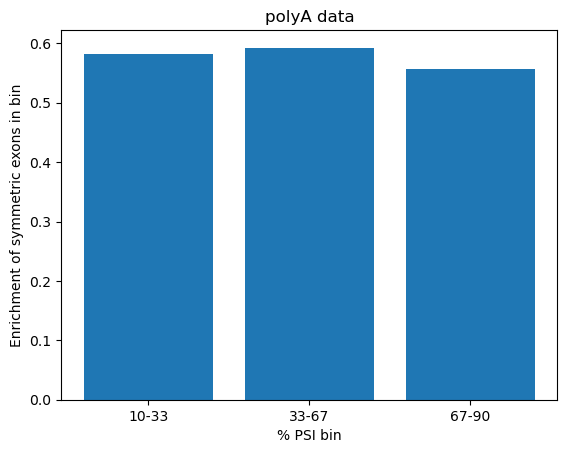

In [138]:
plt.bar(range(1, 4), np.array(polyA_))
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(range(1, 4), ['10-33', '33-67', '67-90'])
plt.title('polyA data')

Text(0.5, 1.0, 'chRNA data')

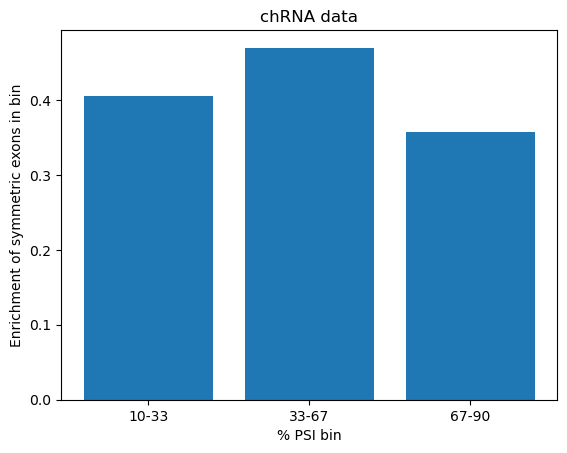

In [161]:
plt.bar(range(1, 4), np.array(polyA_))
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(range(1, 4), ['10-33', '33-67', '67-90'])
plt.title('chRNA data')

In [194]:
x = np.linspace(0.2, 0.9, 8)
chRNA_ = [((df.loc[psi.loc[(psi.mean(axis=1) < i) & (psi.mean(axis=1) >= i- 0.1)].index].LE_n%3)==0).mean() for i in x]


Text(0.5, 1.0, 'chRNA data')

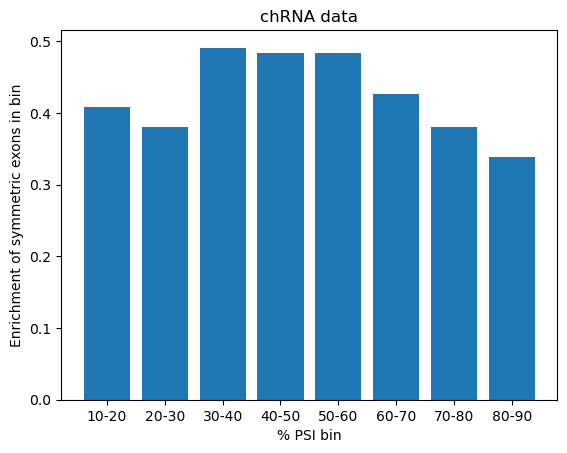

In [195]:
plt.bar(x*10, np.array(chRNA_))
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(range(2, 10), [str((x-1)*10) + '-' + str(x*10) for x in range(2, 10)])
plt.title('chRNA data')

Text(0.5, 1.0, 'polyA data')

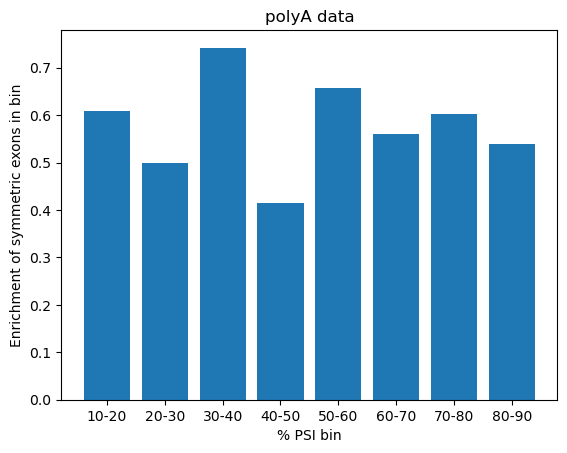

In [185]:
x = np.linspace(0.2, 0.9, 8)
polyA_ = [((df.loc[psi.loc[(psi.mean(axis=1) < i) & (psi.mean(axis=1) >= i- 0.1)].index].LE_n%3)==0).mean() for i in x]
    
plt.bar(x*10, np.array(polyA_))
plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(range(2, 10), [str((x-1)*10) + '-' + str(x*10) for x in range(2, 10)])
plt.title('polyA data')

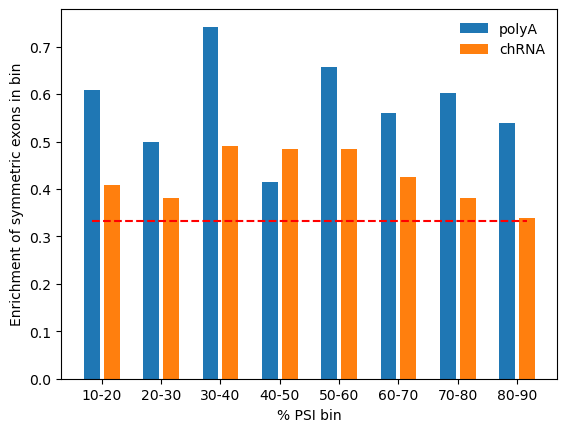

In [222]:
plt.bar(x*30, np.array(polyA_), label='polyA')

plt.bar(x*30+1, np.array(chRNA_), label='chRNA')

plt.ylabel('Enrichment of symmetric exons in bin')
plt.xlabel('% PSI bin')
plt.xticks(np.arange(2, 10)*3+0.5, [str((x-1)*10) + '-' + str(x*10) for x in range(2, 10)])
plt.plot([6, 28], [0.333, 0.333], 'r--')
# plt.title('polyA data')
plt.legend(frameon=False)

In [243]:
((df.loc[psi.loc[(psi.mean(axis=1) < 0.5) & (psi.mean(axis=1) >= 0.4)].index].LE_n%3)==0).mean()

0.41379310344827586

In [248]:
df.loc[psi.loc[(psi.mean(axis=1) < 0.5) & (psi.mean(axis=1) >= 0.4)].index]#.shape

,chrom,donor_c1,receptor_c1,donor_c2,receptor_c2,LE_n
event,,,,,,
HsaEX0015619,chr12,9692931,9693033,9693115,9694759,82
HsaEX0036393,chr12,25052956,25061591,25061653,25062819,62
HsaEX0057280,chr2,241315982,241316421,241316540,241317498,119
HsaEX7010174,chr20,45814470,45815389,45815540,45815853,151
HsaEX0005757,chr6,157174117,157174846,157175005,157180968,159
HsaEX0035661,chr12,51049185,51052091,51052207,51056349,116
HsaEX0010150,chr1,16367308,16391374,16391424,16393227,50
HsaEX0027841,chr20,58895684,58898940,58898985,58903530,45
HsaEX0036952,chr19,40614446,40617099,40617225,40619346,126
